# Heart Disease Diagnosis

## Path Variables and constants

In [1]:
# Constants
TEST_SIZE = 0.10
VAL_SIZE = 0.10

# Path Variables
DATASET_FOLDER = 'datasets/'
MODELS_FOLDER = 'models/'

## Import packages

In [2]:
import random
import pickle
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pandas.plotting import scatter_matrix
from sklearn.svm import LinearSVC, SVC
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix, RocCurveDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RepeatedStratifiedKFold

%matplotlib inline
warnings.filterwarnings("ignore")

## Dataset loading and preprocessing
1. Load dataset
2. Study dataset
3. Visualization (if needed)
4. Preprocessing
5. Normalization
6. Validation Train Test Split

In [3]:
def fetch_data(path):
    dataset_path = DATASET_FOLDER + path
    return pd.read_csv(dataset_path)

dataset = fetch_data('heart_disease.csv')
print('Dataset shape - ', dataset.shape)
dataset.head()

Dataset shape -  (918, 12)


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


Dataset Attributes

* Age : age of the patient [years]
* Sex : sex of the patient [M: Male, F: Female]
* ChestPainType : chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]
* RestingBP : resting blood pressure [mm Hg]
* Cholesterol : serum cholesterol [mm/dl]
* FastingBS : fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]
* RestingECG : resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]
* MaxHR : maximum heart rate achieved [Numeric value between 60 and 202]
* ExerciseAngina : exercise-induced angina [Y: Yes, N: No]
* Oldpeak : oldpeak = ST [Numeric value measured in depression]
* ST_Slope : the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]
* HeartDisease : output class [1: heart disease, 0: Normal]

In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [5]:
dataset.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


In [6]:
dataset['HeartDisease'].value_counts()

HeartDisease
1    508
0    410
Name: count, dtype: int64

The dataset is almost balanced.

In [7]:
# Null value count
dataset.isna().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

In [8]:
col = list(dataset.columns)
num_attribs = []
cat_attribs = []
for i in col:
    if i == 'HeartDisease':
        continue
    if len(dataset[i].unique()) > 6:
        num_attribs.append(i)
    else:
        cat_attribs.append(i)

print('Categorical Attributes :',*cat_attribs)
print('Numerical Attributes :',*num_attribs)

Categorical Attributes : Sex ChestPainType FastingBS RestingECG ExerciseAngina ST_Slope
Numerical Attributes : Age RestingBP Cholesterol MaxHR Oldpeak


In [9]:
mms = MinMaxScaler() # Normalization
ss = StandardScaler() # Standardization

df1 = dataset.copy(deep = True)

le = LabelEncoder()

df1['Sex'] = le.fit_transform(df1['Sex'])
df1['ChestPainType'] = le.fit_transform(df1['ChestPainType'])
df1['RestingECG'] = le.fit_transform(df1['RestingECG'])
df1['ExerciseAngina'] = le.fit_transform(df1['ExerciseAngina'])
df1['ST_Slope'] = le.fit_transform(df1['ST_Slope'])

df1['Oldpeak'] = mms.fit_transform(df1[['Oldpeak']])
df1['Age'] = ss.fit_transform(df1[['Age']])
df1['RestingBP'] = ss.fit_transform(df1[['RestingBP']])
df1['Cholesterol'] = ss.fit_transform(df1[['Cholesterol']])
df1['MaxHR'] = ss.fit_transform(df1[['MaxHR']])
df1.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,-1.433140,1,1,0.410909,0.825070,0,1,1.382928,0,0.295455,2,0
1,-0.478484,0,2,1.491752,-0.171961,0,1,0.754157,0,0.409091,1,1
2,-1.751359,1,1,-0.129513,0.770188,0,2,-1.525138,0,0.295455,2,0
3,-0.584556,0,0,0.302825,0.139040,0,1,-1.132156,1,0.465909,1,1
4,0.051881,1,2,0.951331,-0.034755,0,1,-0.581981,0,0.295455,2,0


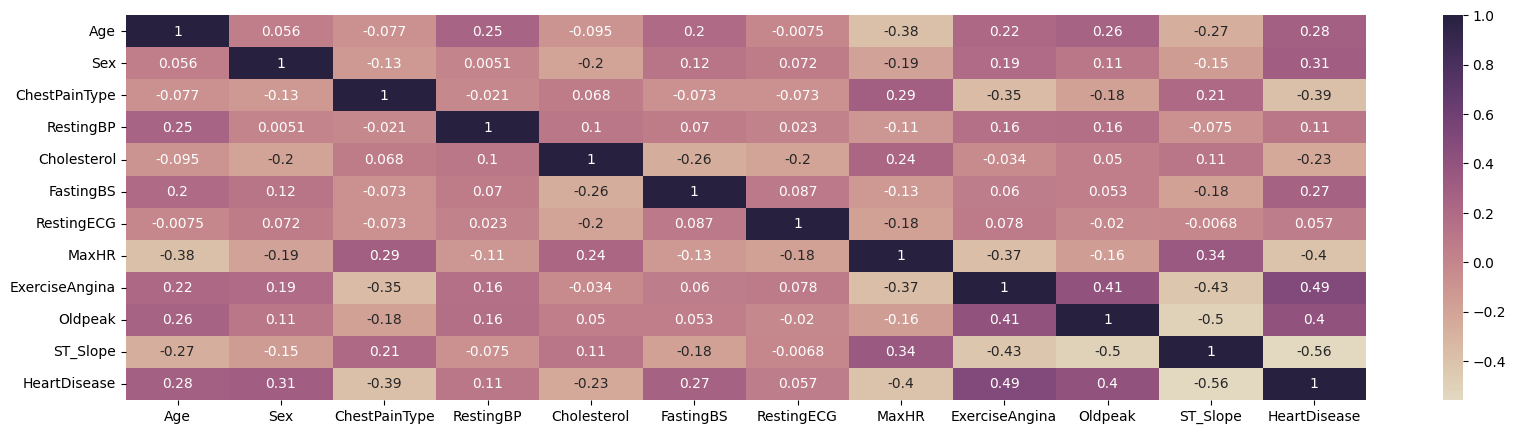

In [10]:
colors = sns.color_palette("ch:s=-.2,r=.6", as_cmap=True)


plt.figure(figsize = (20,5))
sns.heatmap(df1.corr(),cmap = colors,annot = True);

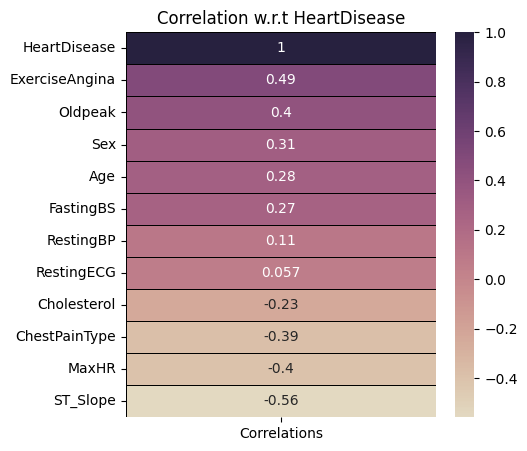

In [11]:
# Checking only for HeartDisease with all other attributes
corr = df1.corrwith(df1['HeartDisease']).sort_values(ascending = False).to_frame()
corr.columns = ['Correlations']
plt.subplots(figsize = (5,5))
sns.heatmap(corr,annot = True,cmap = colors,linewidths = 0.4,linecolor = 'black');
plt.title('Correlation w.r.t HeartDisease');

Based on above values, all attributes other than RestingBP and RestingECG seem to be related either positively or negatively. Hence we will consider all the attributes other than these two.

In [12]:
num_attribs.remove('RestingBP')
cat_attribs.remove('RestingECG')
attributes = num_attribs + cat_attribs

label = 'HeartDisease'

X_train_val, X_test, y_train_val, y_test = train_test_split(dataset[attributes], dataset[label], 
                                                            test_size = TEST_SIZE, 
                                                            stratify = dataset[label], 
                                                            random_state = 42)

# If we have larger dataset, we may also use val sets, but for now will stick to only train and test.

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, 
                                                            test_size = VAL_SIZE, 
                                                            stratify = y_train_val,
                                                            random_state = 42)

In [13]:
print('Train split size: X - {}, y - {}'.format(X_train.shape, y_train.shape))
print('Validation split size: X - {}, y - {}'.format(X_val.shape, y_val.shape))
print('Test split size: X - {}, y - {}'.format(X_test.shape, y_test.shape))

Train split size: X - (743, 9), y - (743,)
Validation split size: X - (83, 9), y - (83,)
Test split size: X - (92, 9), y - (92,)


In [14]:
X_train.head(10)

,Age,Cholesterol,MaxHR,Oldpeak,Sex,ChestPainType,FastingBS,ExerciseAngina,ST_Slope
256,55,394,150,0.0,F,ATA,0,N,Up
757,50,233,163,0.6,M,NAP,0,N,Flat
355,67,0,125,0.0,M,TA,0,N,Flat
514,43,0,120,0.5,M,ASY,0,N,Up
722,60,258,157,2.6,F,ASY,0,N,Flat
707,54,266,109,2.2,M,ASY,0,Y,Flat
662,44,197,177,0.0,M,ASY,0,N,Up
467,63,0,130,0.1,F,ATA,0,N,Up
681,51,261,186,0.0,M,ASY,0,Y,Up
139,43,247,130,2.0,M,ASY,0,Y,Flat


In [15]:
# We will create a custom pipeline that will handle the null values and normalization

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])

full_pipeline = ColumnTransformer([
        ("cat", OneHotEncoder(), cat_attribs),
        ("num", num_pipeline, num_attribs),
    ])

X_train_transformed = full_pipeline.fit_transform(X_train)

# imputer = SimpleImputer(strategy="median")
# X_train_transformed = imputer.fit_transform(X_train)

In [16]:
X_train_transformed[1,:]

array([ 0.        ,  1.        ,  0.        ,  0.        ,  1.        ,
        0.        ,  1.        ,  0.        ,  1.        ,  0.        ,
        0.        ,  1.        ,  0.        , -0.39592974,  0.26343702,
        1.03103305, -0.27215248])

## Training Various Models

1. Cross Validation on various models
2. Choose best model

* We wil try fitting the data to 3 models - 
1. Logistic Regression Model
2. SVM Classifier
3. Random Forest Classifier

* For each of the model, we will use the cross val score to fit and evaluate over 5 folds of train data.

In [17]:
def model(classifier, X_train_transformed, y_train):
    
    classifier.fit(X_train_transformed,y_train)
    prediction = classifier.predict(X_train_transformed)
    cv = RepeatedStratifiedKFold(n_splits = 10,n_repeats = 3,random_state = 1)
    print("Accuracy : ",'{0:.2%}'.format(accuracy_score(y_train, prediction)))
    print("Cross Validation Score : ",'{0:.2%}'.format(cross_val_score(classifier, X_train_transformed, y_train,cv = cv,scoring = 'roc_auc').mean()))
    print("ROC_AUC Score : ",'{0:.2%}'.format(roc_auc_score(y_train, prediction)))
    RocCurveDisplay.from_estimator(classifier, X_train_transformed, y_train)
    plt.title('ROC_AUC_Plot')
    plt.show()

def model_evaluation(classifier, X_val, y_val):
    
    # Confusion Matrix
    cm = confusion_matrix(y_val,classifier.predict(full_pipeline.transform(X_val)))
    names = ['True Neg','False Pos','False Neg','True Pos']
    counts = [value for value in cm.flatten()]
    percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(names,counts,percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cm,annot = labels,cmap = colors,fmt ='')
    
    # Classification Report
    print(classification_report(y_val, classifier.predict(full_pipeline.transform(X_val))))

Accuracy :  86.00%
Cross Validation Score :  92.02%
ROC_AUC Score :  85.70%


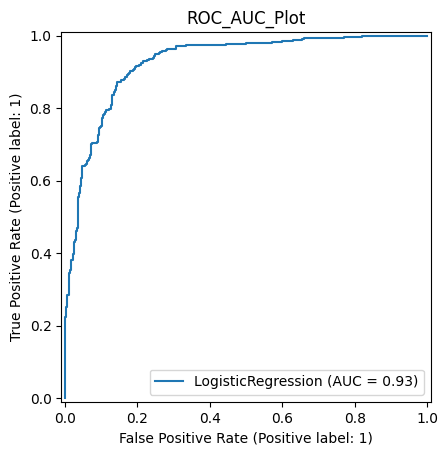

              precision    recall  f1-score   support

           0       0.86      0.84      0.85        37
           1       0.87      0.89      0.88        46

    accuracy                           0.87        83
   macro avg       0.87      0.86      0.87        83
weighted avg       0.87      0.87      0.87        83



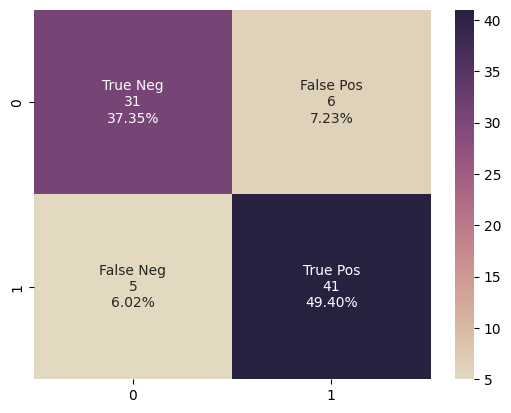

In [18]:
# Logistic Regression Classifier
log_clf = LogisticRegression(solver='lbfgs', C=10, penalty='l2', max_iter=10000, random_state = 42)
model(log_clf, X_train_transformed, y_train)
model_evaluation(log_clf, X_val, y_val)

Accuracy :  86.68%
Cross Validation Score :  92.10%
ROC_AUC Score :  86.25%


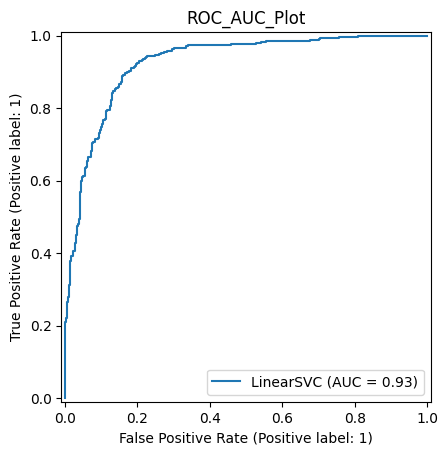

              precision    recall  f1-score   support

           0       0.86      0.86      0.86        37
           1       0.89      0.89      0.89        46

    accuracy                           0.88        83
   macro avg       0.88      0.88      0.88        83
weighted avg       0.88      0.88      0.88        83



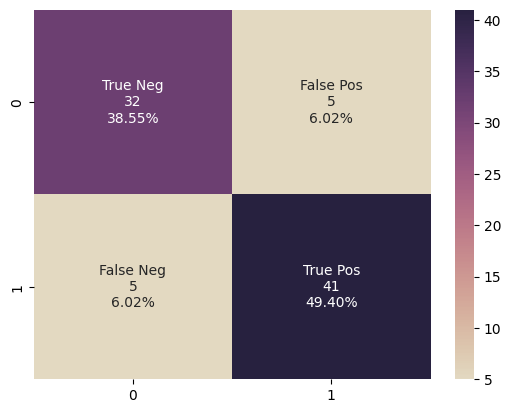

In [19]:
lin_clf = LinearSVC(loss="hinge", C=0.5, random_state=42)
model(lin_clf, X_train_transformed, y_train)
model_evaluation(lin_clf, X_val, y_val)

Accuracy :  89.50%
Cross Validation Score :  92.36%
ROC_AUC Score :  88.92%


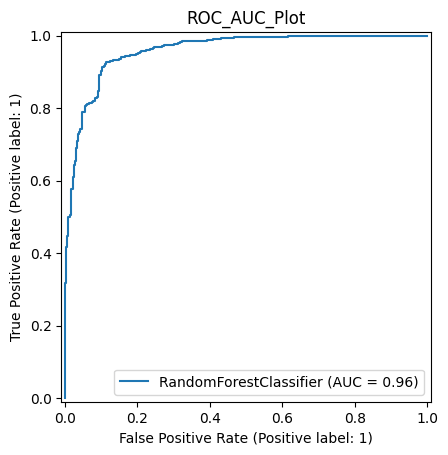

              precision    recall  f1-score   support

           0       0.89      0.89      0.89        37
           1       0.91      0.91      0.91        46

    accuracy                           0.90        83
   macro avg       0.90      0.90      0.90        83
weighted avg       0.90      0.90      0.90        83



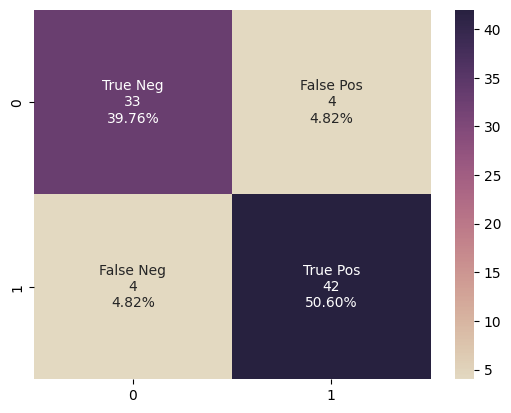

In [20]:
forest_clf = RandomForestClassifier(max_depth=5, n_estimators=500, criterion='gini', random_state = 42)
model(forest_clf, X_train_transformed, y_train)
model_evaluation(forest_clf, X_val, y_val)

Accuracy :  87.21%
Cross Validation Score :  91.72%
ROC_AUC Score :  86.68%


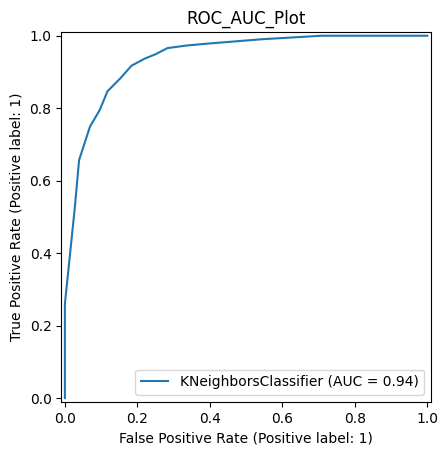

              precision    recall  f1-score   support

           0       0.89      0.84      0.86        37
           1       0.88      0.91      0.89        46

    accuracy                           0.88        83
   macro avg       0.88      0.88      0.88        83
weighted avg       0.88      0.88      0.88        83



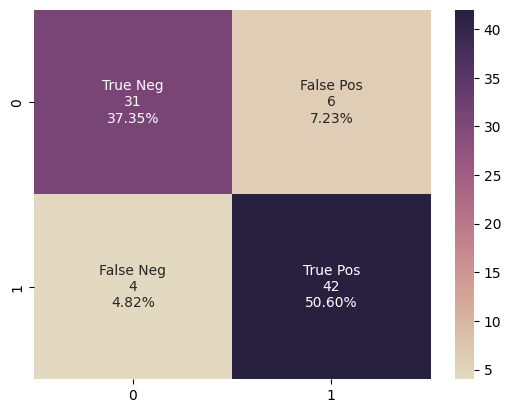

In [21]:
knn_clf = KNeighborsClassifier(n_neighbors=15, p=2, metric='euclidean')
model(knn_clf, X_train_transformed, y_train)
model_evaluation(knn_clf, X_val, y_val)

All the models have more than 85% overall accuracy. We will be considering the recall for each of the model as it is important that the model is able to identify all the true positive instance (patients who have heart disease). The Random Forests model has a 91% recall. that means out of 100 positive instances, the model detected 91%. We can further improve this by performing further feature engineering and feature importance. 

## Evaluation on best model
1. Train again on best model and get evaluation
2. Test set evaluation
3. Present metrics

In [22]:
param_grid = {
    'max_depth':[5, 9, 13, 17, 21, None], 
    'n_estimators': [300, 500, 700, 1000]
}

forest_clf = RandomForestClassifier(criterion='gini', random_state = 42)
grid_search = GridSearchCV(forest_clf, param_grid, cv=10,
                           return_train_score=True, scoring='recall')
grid_search.fit(X_train_transformed, y_train)

GridSearchCV(cv=10, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [5, 9, 13, 17, 21, None],
                         'n_estimators': [300, 500, 700, 1000]},
             return_train_score=True, scoring='recall')

In [23]:
print(grid_search.best_score_)
print(grid_search.best_params_)

0.9025551684088271
{'max_depth': 5, 'n_estimators': 500}


In [24]:
forest_clf = grid_search.best_estimator_

In [25]:
X_test_transformed = full_pipeline.transform(X_test)
y_pred = lin_clf.predict(X_test_transformed)

In [26]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.90      0.88      0.89        41
           1       0.90      0.92      0.91        51

    accuracy                           0.90        92
   macro avg       0.90      0.90      0.90        92
weighted avg       0.90      0.90      0.90        92



From the above results, the model has a 92% recall rate over the test data, which is good, in medical use cases, the model is required to identify all the true positive cases.

## Full data training
1. Train on full data
2. Pickle trained model


In [27]:
X, y = dataset[attributes], dataset[label]

In [28]:
X_transformed = full_pipeline.fit_transform(X)

In [29]:
forest_clf = RandomForestClassifier(max_depth = 5, n_estimators=500, criterion='gini', random_state = 42)

In [30]:
forest_clf.fit(X_transformed, y)

RandomForestClassifier(max_depth=5, n_estimators=500, random_state=42)

In [34]:
random_index = random.randint(0, len(X_transformed)) # 914 - +ve instance
instance = X_transformed[random_index]
label = y[random_index]

print('Index - ', random_index,'\n')
print('Instance - ', instance,'\n')
print('Label - ', label)
print('Heart Disease' if label==1 else 'No Heart Disease')

Index -  341 

Instance -  [ 0.          1.          1.          0.          0.          0.
  0.          1.          0.          1.          1.          0.
  0.          1.11261011 -1.81843477 -0.89636694  0.3870923 ] 

Label -  1
Heart Disease


In [35]:
prediction = forest_clf.predict([instance])
print('Heart Disease Detected' if prediction[0]==1 else 'Heart Disease NOT Detected')

Heart Disease Detected


In [33]:
# Saving the model
dump = {
    'model' : forest_clf,
    'report' : report
}

filename = 'heart_disease_forest_clf.pkl'

pickle.dump(dump, open(MODELS_FOLDER+filename, 'wb'))